## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Spatio-temporal Gassusian Process Modelling Tutorial


In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../Code')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
from tqdm.notebook import tqdm

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

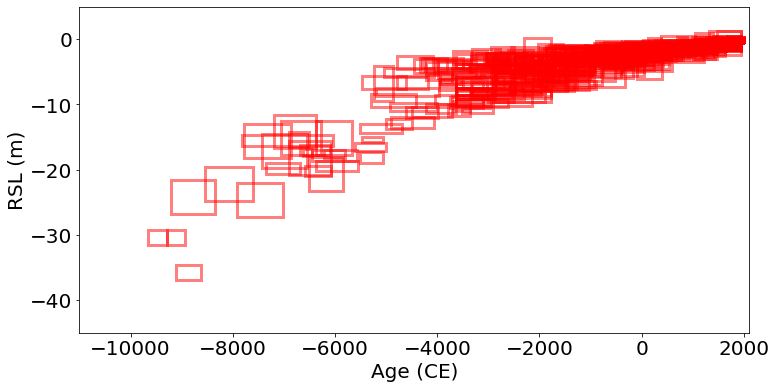

In [72]:
US_data = pd.read_csv('../Data/US_Atlantic_Coast_for_ESTGP.csv')
SLIP_index = US_data['Limiting']==0
US_data = US_data[SLIP_index]
US_rsl = US_data['RSL']
US_rsl_2sd =( US_data['RSLer_up_2sd']+US_data['RSLer_low_2sd'])/2 #average up and low 2std
US_rsl_age = -(US_data['Age']-1950) #convert age from BP to CE
US_rsl_age_2sd = (US_data['Age_low_er_2sd']+US_data['Age_up_er_2sd'])/2 #average up and low 2std
US_site_name = US_data['Region']
US_lon = US_data['Longitude']
US_lat = US_data['Latitude']
US_coord = np.vstack((US_lat,US_lon)).T

age = torch.tensor(US_rsl_age.values)
coord = torch.tensor(US_coord)
y = torch.tensor(US_rsl.values)
y_sigma = torch.tensor(US_rsl_2sd.values/2).flatten()
x_sigma = torch.tensor(US_rsl_age_2sd.values/2).flatten()
X = torch.hstack([age[:,None],coord])

ax = PSTHM.plot_uncertainty_boxes(age,y, x_sigma*2,y_sigma*2)
ax.set_xlim(-11000,2100)
ax.set_ylim(-45,5);

In [7]:
st = time.time() 
pyro.clear_param_store()
#define global temporal kernel
global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(30000.), torch.tensor(1000000.)))
global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))
#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(1e-2)))
regional_linear_spatial_kernel = PSTHM.RBF(input_dim=1,geo=True)
regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.2), torch.tensor(0.21)))
regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)
#define regionally non-linar spatio-temporal kernel
regional_nl_temporal_kernel = PSTHM.Matern52(input_dim=1,geo=False)
regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1000.), torch.tensor(5000.)))
regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.**2)))
regional_nl_spatial_kernel = PSTHM.Matern32(input_dim=1,geo=False)
regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.2), torch.tensor(0.21)))
regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)
#define locally non-linar spatio-temporal kernel
local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(1000.)))
local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(40.**2)))
local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.051)))
local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)
#define whitenoise kernel
whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))
#combine all kernels
combined_sp_kernel = gp.kernels.Sum(regional_linear_kernel,regional_nl_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,global_kernel)

gpr = PSTHM.GPRegression_V(X, y, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,lr=0.1,num_iteration=1000)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 325.775
Execution time: 146.908 s


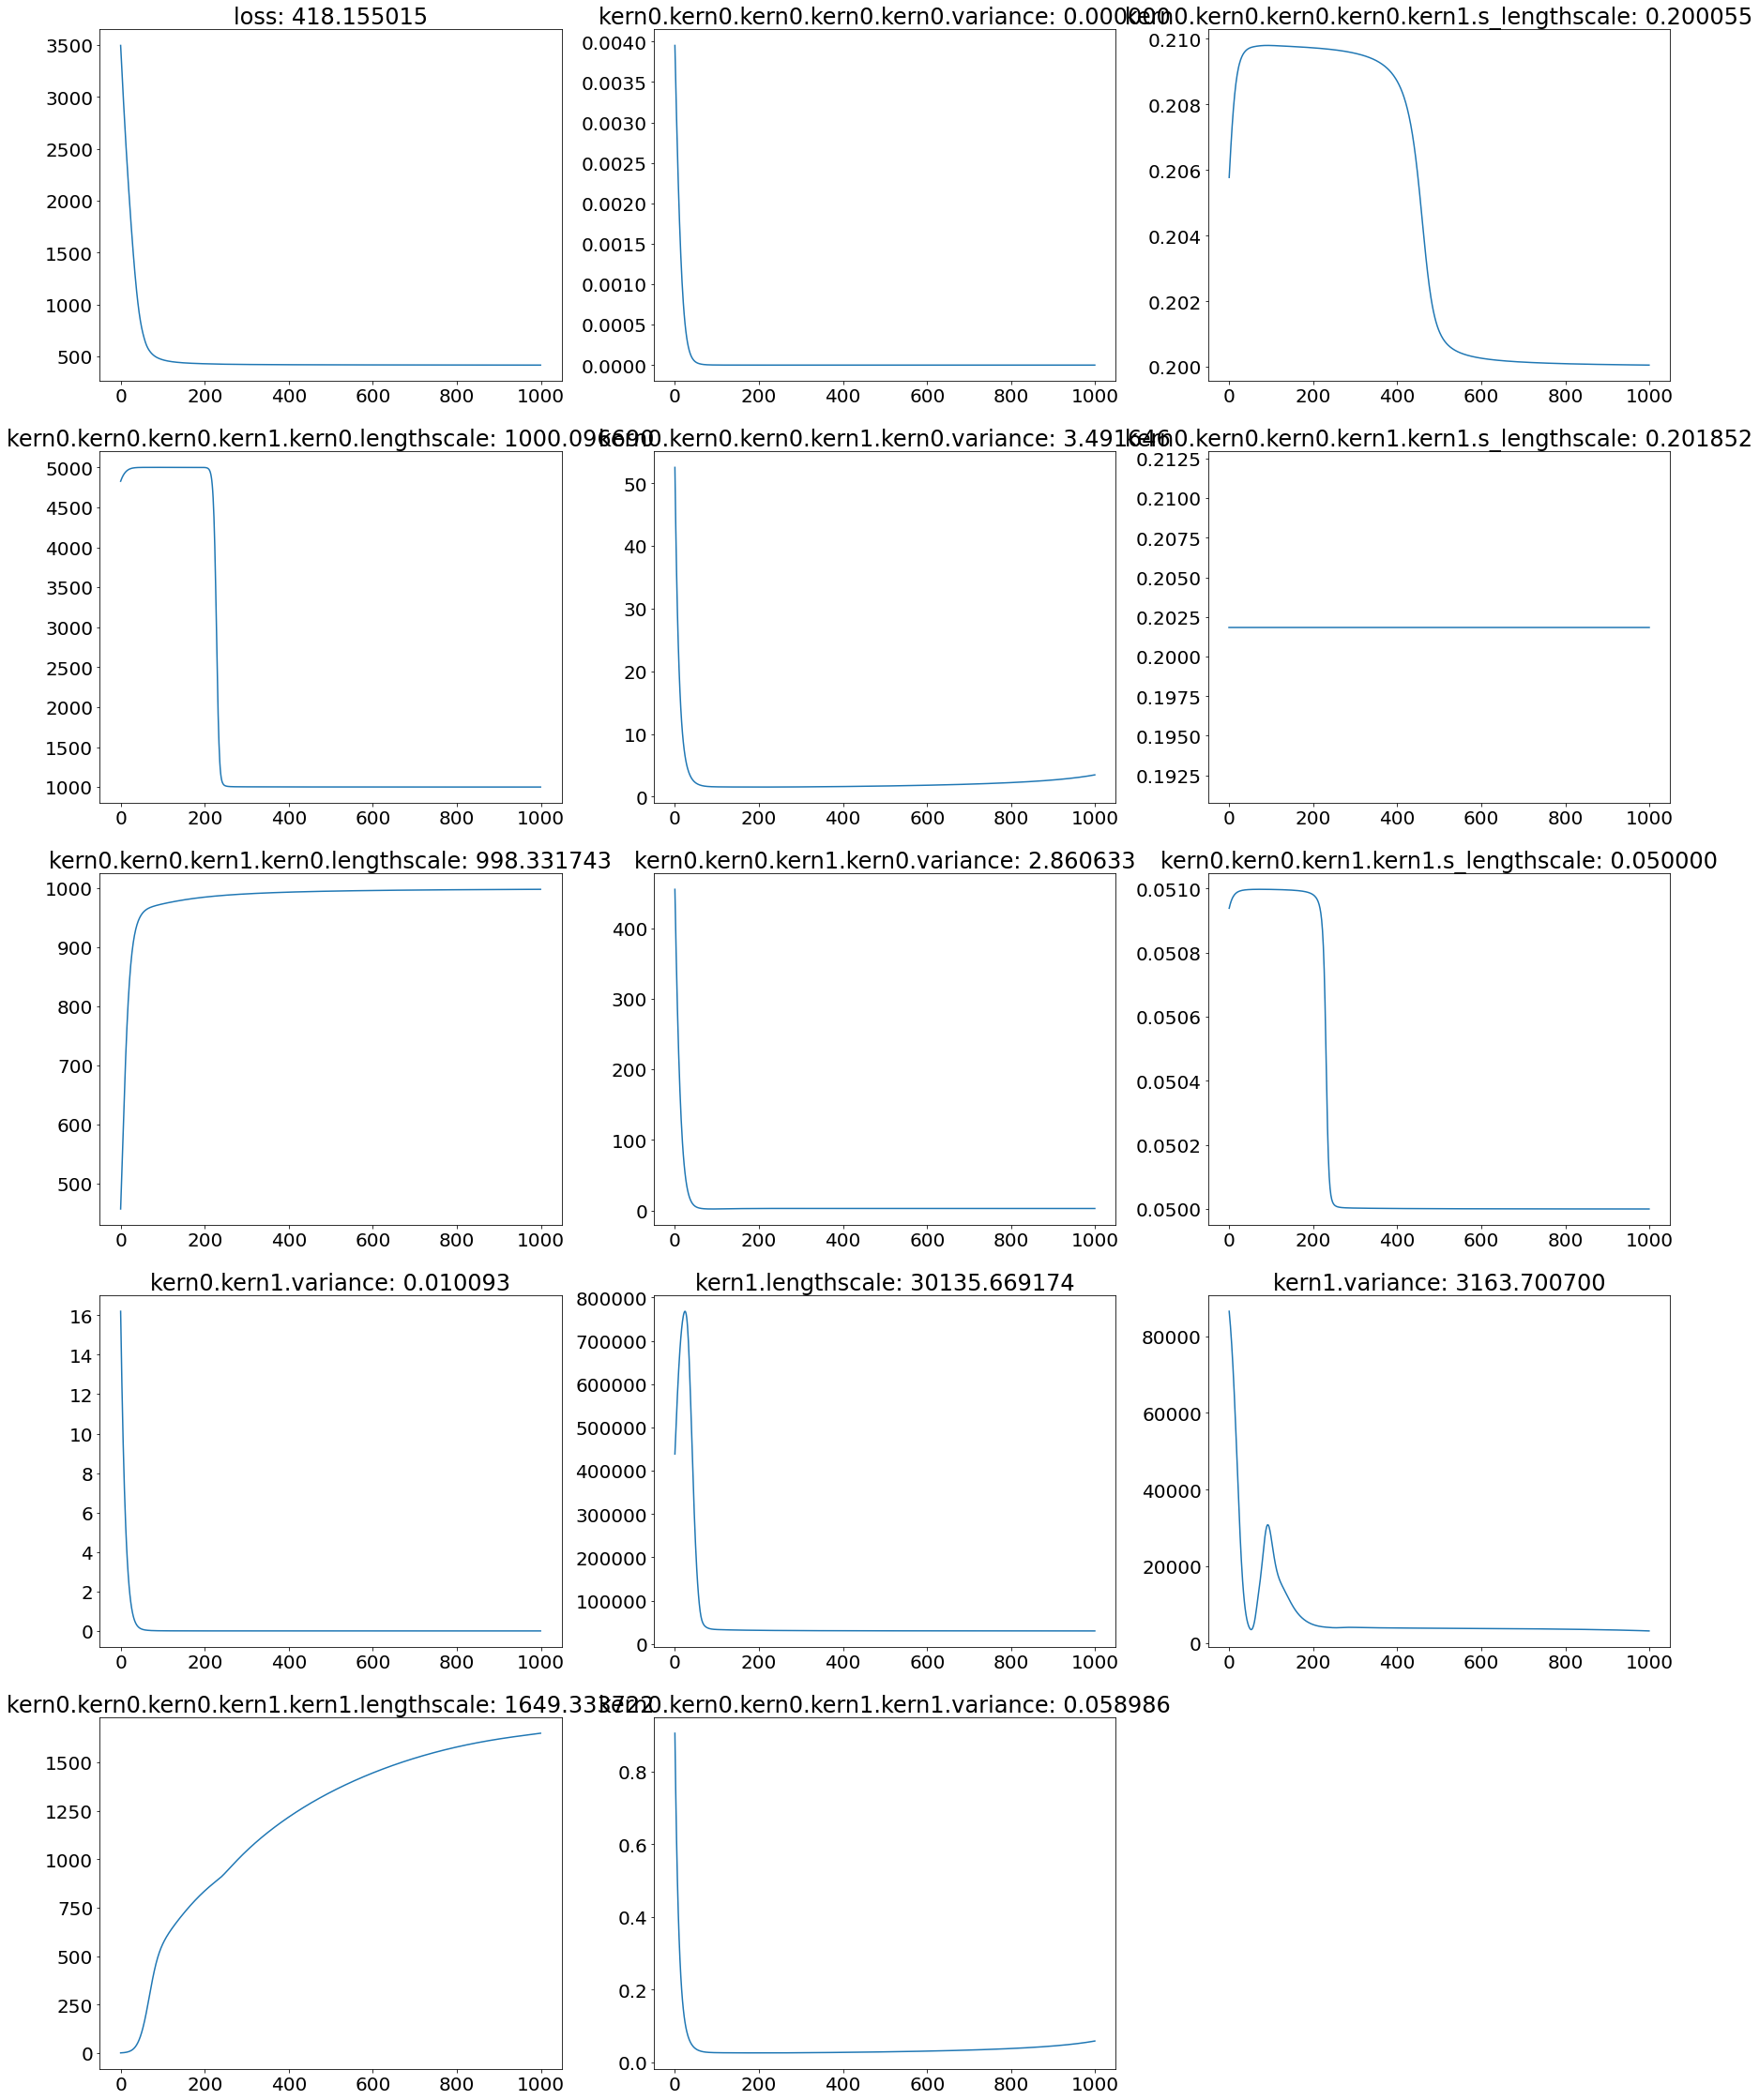

In [8]:
axes = PSTHM.plot_track_list(track_list)

In [9]:
def gen_pred_matrix(age,lat,lon):

    age = np.array(age)
    lat = np.array(lat)
    lon = np.array(lon)

    lat_matrix,lon_matrix,age_matrix = np.meshgrid(lat,lon,age)
    
    output_matrix = torch.tensor(np.hstack([age_matrix.flatten()[:,None],lat_matrix.flatten()[:,None],lon_matrix.flatten()[:,None]]))
    return output_matrix

test_age = np.arange(-6000,2000,10)
test_X = gen_pred_matrix(test_age,[42.041625000000025],[-70.62785000000001])
y_mean, y_var = gpr(test_X.double(), full_cov=True)
y_std = y_var.diag().sqrt()



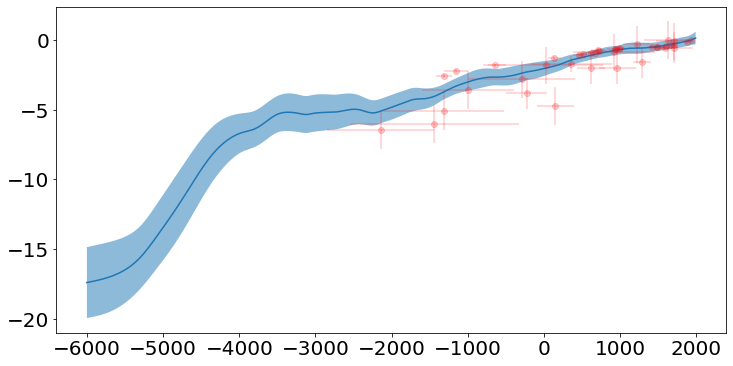

In [10]:
C_index =np.array( US_site_name=='Massachusetts')
plt.errorbar(X[C_index,:1].flatten(),y[C_index],yerr=y_sigma[C_index]*2,xerr=x_sigma[C_index]*2,
             fmt='o',alpha=0.2,color='r')

plt.plot(test_X[:,0],y_mean.detach().numpy() )
plt.fill_between(test_X[:,0],y_mean.detach().numpy()+2*y_std.detach().numpy(),y_mean.detach().numpy()-2*y_std.detach().numpy(),alpha=0.5)


In [88]:

x_test = torch.arange(-500,2025,5.)
lon_test = np.arange(np.min(US_lon)-2,np.max(US_lon)+2,0.5)
lat_test = np.arange(np.min(US_lat)-2,np.max(US_lat)+2,0.5)
lon_matrix,lat_matrix = np.meshgrid(lon_test,lat_test)
test_X = torch.tensor(np.hstack([np.ones(len(lon_matrix.flatten()))[:,None]*-6000,lat_matrix.flatten()[:,None],lon_matrix.flatten()[:,None]]))
test_X2 = torch.tensor(np.hstack([np.ones(len(lon_matrix.flatten()))[:,None]*-2000,lat_matrix.flatten()[:,None],lon_matrix.flatten()[:,None]]))

y_mean, y_var = gpr(test_X.double(), full_cov=True)
y_mean2, y_var2 = gpr(test_X2.double(), full_cov=True)
y_std = y_var.diag().sqrt()
y_std2 = y_var2.diag().sqrt()


In [103]:
np.max(US_lat)-2

42.683

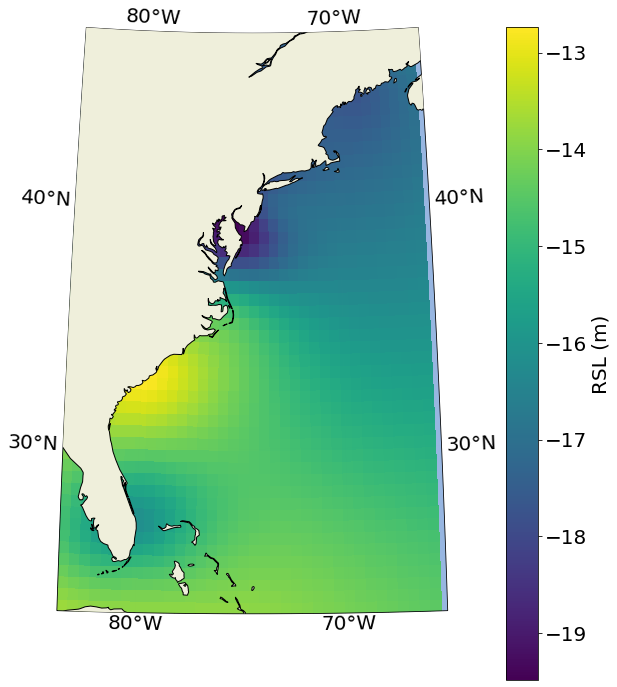

In [112]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Define projections
dataproj = ccrs.PlateCarree()
mapproj  = ccrs.Stereographic(central_longitude=-74.524)

# Plot figure
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=mapproj)

# Add some features
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=10)
ax.add_feature(cartopy.feature.OCEAN)

# Lon and Lat Boundaries
xlim = [np.min(US_lon)-2,np.max(US_lon)+2]
ylim = [np.min(US_lat)-2,np.max(US_lat)+2]
lower_space = 3 
rect = mpath.Path([[xlim[0], ylim[0]],
                   [xlim[1], ylim[0]],
                   [xlim[1], ylim[1]],
                   [xlim[0], ylim[1]],
                   [xlim[0], ylim[0]],
                   ]).interpolated(20)
proj_to_data   = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_extent([xlim[0], xlim[1], ylim[0] - lower_space, ylim[1]])
#
# lats/lons labels and ticks
gl = ax.gridlines(draw_labels=False,x_inline=False,y_inline=False, crs=ccrs.PlateCarree(),linewidth=0.005)
gl.xlocator = mticker.FixedLocator([-80, -70,-65])
gl.ylocator = mticker.FixedLocator([20, 30,40,50])
gl.bottom_labels = True
gl.left_labels   = True
gl.top_labels    = True
gl.right_labels  = True

cax = ax.pcolor(lon_matrix,lat_matrix,(y_mean).detach().numpy().reshape(lon_matrix.shape), transform=ccrs.PlateCarree())

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('RSL (m)')